TRABAJO FINAL DE LA MATERIA - MAIE 2024

Alumna: Escalante, Guadalupe Sol

El programa deberá hacer como mínimo:

● descomprimir el archivo ZIP

● realizar un análisis exploratorio de los datos y metadatos de la imagen y mostrar algunos datos de estos

● identificar posibles outlier y enmascararlos a valores nan

● calcular mascara

● recortar bandas

● calcular indice


Se importan las librerías a utilizar

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import copy
from scipy import ndimage
#!pip install rasterio
import rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 12.9 MB/s eta 0:00:00


Se monta el directorio en drive en el que trabajaremos

In [182]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/MAIE/PLANNING/TF')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se descomprimen los archivos

In [183]:
import zipfile
import os

# primer archivo zip
ruta_zip = '/content/drive/My Drive/MAIE/PLANNING/TF/los_molinos_L8_2023.zip'
directorio_destino_1 = 'zip_descomprimido'
os.makedirs(directorio_destino_1)

with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
     zip_ref.extractall(directorio_destino_1)
     print("Primer archivo ZIP descomprimido")

# segundo archivo zip
ruta_zip_2 = '/content/zip_descomprimido/los_molinos_L8_2023/Los-Molinos_2023-02-07_2_all_bands.zip'
directorio_destino_2 = 'febrero_2023_descomprimido'
os.makedirs(directorio_destino_2)

with zipfile.ZipFile(ruta_zip_2, 'r') as zip_ref:
     zip_ref.extractall(directorio_destino_2)
     print("Segundo archivo ZIP descomprimido")


FileExistsError: [Errno 17] File exists: 'zip_descomprimido'

cargamos imagenes a utilizar y dividimos por 255 para normalizarlas

bandas elegidas:
- para NDVI: 4 y 5  correspondientes al rojo e infrarrojo cercano respectivamente
- Para MNDWI: 3 y 6 correspondientes al verde e infrarrojo medio respectivamente






In [164]:
# ruta de las imagenes en Google Drive
ruta_imagenes = '/content/febrero_2023_descomprimido/'
imagenes = [B3, B4, B5, B6]
n=3
for imagen in imagenes:
  ruta_imagen = ruta_imagenes + f'2023-02-07.SR_B{n}.tif'
  f'B{n}' == plt.imread(ruta_imagen)/255
  n=n+1


Antes de comenzar a trabajar con las imagenes, analizamos la imagen de calidad para detectar la presencia de nubes.

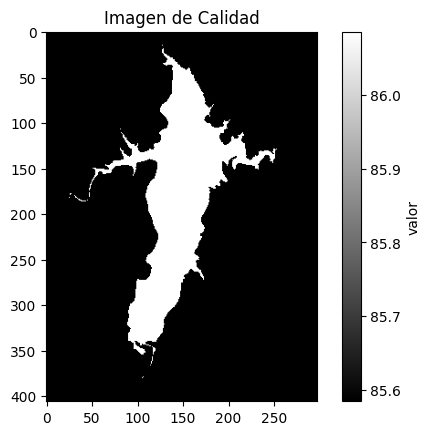

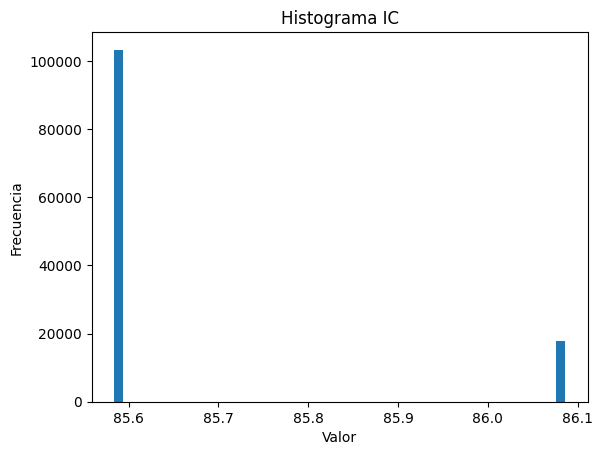

In [181]:
ruta_IC = ruta_imagenes + f'2023-02-07.QA_PIXEL.tif'
IC = plt.imread(ruta_IC)/255

#visualizacion
plt.imshow(IC,cmap='gray')
plt.title('Imagen de Calidad')
plt.colorbar(label='valor')
plt.show()
print('\n')

#histograma
IC2 = IC.flatten() #aplanamos la imagen para que pueda ser procesada por la función hist().
plt.hist(IC2, bins=50)
plt.title('Histograma IC')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

Podemos notar que solo se encuentran dos valores que corresponden al agua y no-agua por lo que no hay nubes a filtrar.

Representamos cada imagen en escala de grises y agregamos informacion

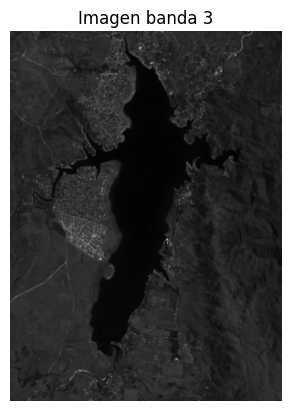

información de la imagen
dimensiones: 406x298
valor mínimo: 29.75
valor máximo: 81.18
SRC: EPSG:32620
formato:GTiff



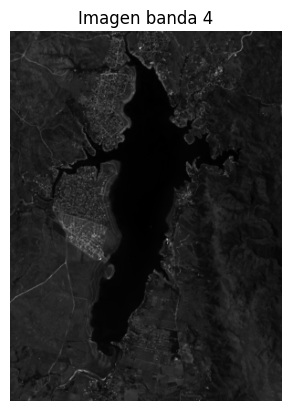

información de la imagen
dimensiones: 406x298
valor mínimo: 29.09
valor máximo: 90.20
SRC: EPSG:32620
formato:GTiff



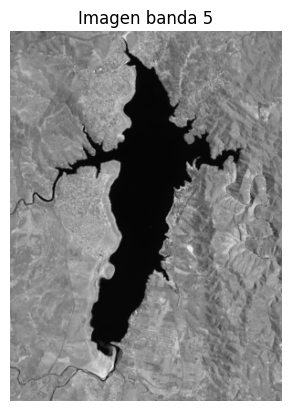

información de la imagen
dimensiones: 406x298
valor mínimo: 28.18
valor máximo: 103.79
SRC: EPSG:32620
formato:GTiff



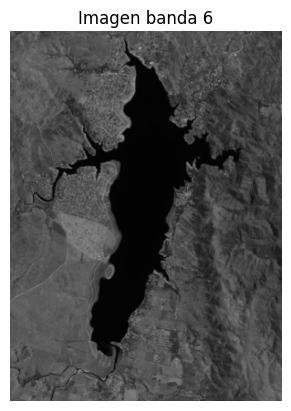

información de la imagen
dimensiones: 406x298
valor mínimo: 28.01
valor máximo: 129.56
SRC: EPSG:32620
formato:GTiff



In [165]:
imagenes = [B3, B4, B5, B6]
n=3

for imagen in imagenes:

    #representacion
    plt.imshow(imagen,cmap='gray')
    plt.axis('off')
    plt.title(f"Imagen banda {n}")
    plt.show()

    #calculo e impresion de dimensiones y valores min/max
    filas, columnas = imagen.shape
    min_val = np.nanmin(imagen)
    max_val = np.nanmax(imagen)
    print("información de la imagen")
    print(f"dimensiones: {filas}x{columnas}")
    print(f"valor mínimo: {min_val:.2f}")
    print(f"valor máximo: {max_val:.2f}")

    #utilizacion de rasterio para imprimir SRC y formato
    ruta_imagen = ruta_imagenes + f'2023-02-07.SR_B{n}.tif'
    with rasterio.open(ruta_imagen) as img:
      print(f"SRC: {img.crs}")
      print(f"formato:{img.driver}\n")

    n=n+1


Se calcula NDVI. Graficamos (escala entre el minimo y maximo de la imagen)

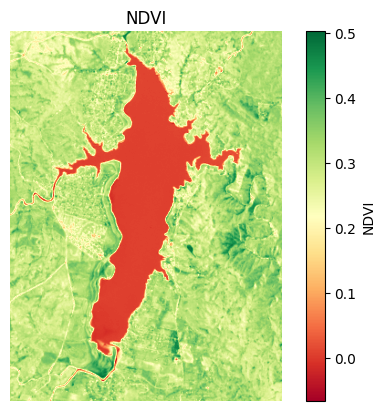

In [15]:
ndvi = (B5 - B4)/(B5 + B4)

plt.imshow(ndvi, cmap='RdYlGn')
plt.axis('off')
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.show()



Se calcula MNDWI. Graficamos (escala entre el minimo y maximo de la imagen).

Nota: Los valores negativos generalmente representan agua, mientras que los valores positivos pueden representar tierra u otras características terrestres

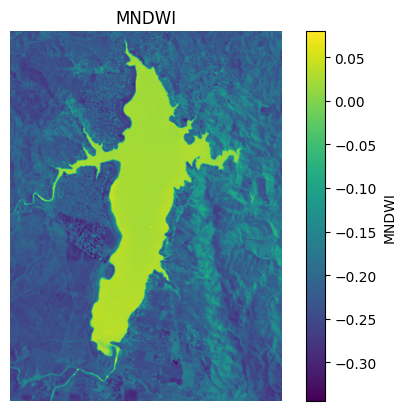

In [16]:
mndwi = (B3 - B6)/(B3 + B6)

plt.imshow(mndwi)
plt.axis('off')
plt.colorbar(label='MNDWI')
plt.title('MNDWI')
plt.show()

Se hace un histograma de MNDWI

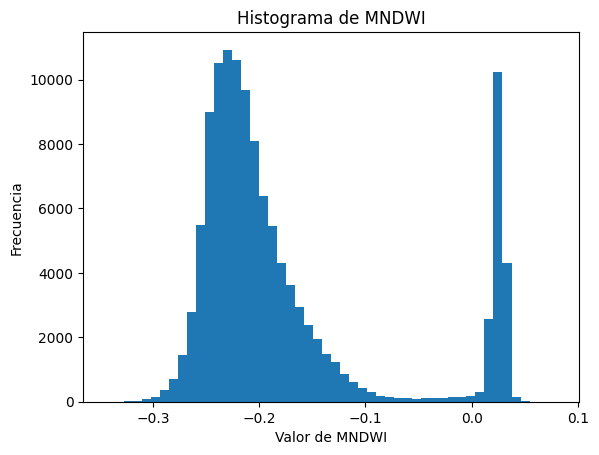

In [17]:
#aplanamos la imagen para que pueda ser procesada por la función hist().
mndwi_flat = mndwi.flatten()

#graficamos
plt.hist(mndwi_flat, bins=50)
plt.title('Histograma de MNDWI')
plt.xlabel('Valor de MNDWI')
plt.ylabel('Frecuencia')
plt.show()

Se realiza una mascara con los valores mayores a 0 correspondientes a lo que no es agua

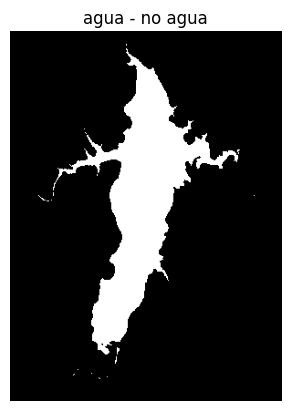

In [18]:
mascara = mndwi > 0

# Visualizar la máscara de agua
plt.imshow(mascara, cmap='gray')
plt.title('agua - no agua')
plt.axis('off')
plt.show()

Se "corta" la imagen de NDVI. Se le asignan valores NaN a todo lo que no es agua.

In [19]:
ndvi_cortado = ndvi.copy() #realizamos el proceso sobre una copia
ndvi_cortado[~mascara] = np.nan


Se calcula un histograma de la nueva imagen para ver la distribución de valores de NDVI adentro del lago:

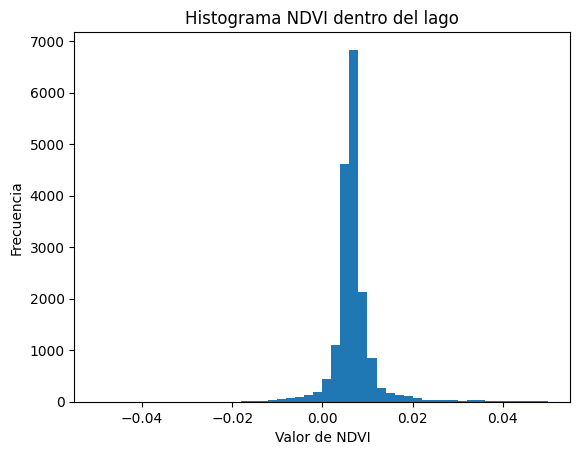

In [20]:
#aplanamos la imagen para que pueda ser procesada por la función hist().
ndvi_cortado_flat = ndvi_cortado.flatten()

#grafico entre -0.05 y 0.05 para ver con mas detalle
plt.hist(ndvi_cortado_flat, bins=50, range=(-0.05, 0.05))
plt.title('Histograma NDVI dentro del lago')
plt.xlabel('Valor de NDVI')
plt.ylabel('Frecuencia')
plt.show()

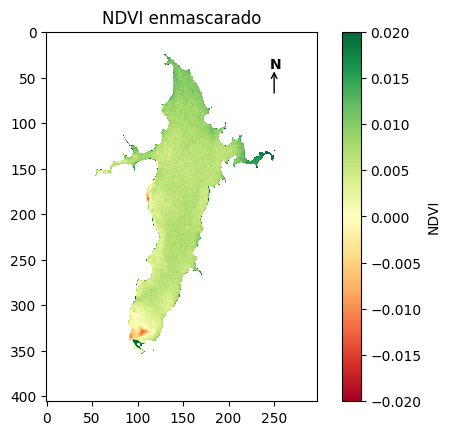

In [184]:
# Visualizamos la imagen cortada
plt.imshow(ndvi_cortado, cmap='RdYlGn', vmin=-0.02, vmax=0.02)
plt.title('NDVI enmascarado')
plt.colorbar(label='NDVI')

x=250
y=70
plt.annotate('', xy=(x, y - 30), xytext=(x, y), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.text(245, 40, "N", fontsize=10, color='black', fontweight='bold')

plt.savefig('ndvi_02-2023_L8.tif', dpi=300, bbox_inches='tight')
plt.show()